In [ ]:
!apt-get install -y fonts-nanum*
!rm -rf /root/.cache/matplotlib/* # 폰트 캐시 재설정

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Note, selecting 'fonts-nanum-extra' for glob 'fonts-nanum*'
Note, selecting 'fonts-nanum-coding' for glob 'fonts-nanum*'
Note, selecting 'fonts-nanum-eco' for glob 'fonts-nanum*'
Note, selecting 'fonts-nanum' for glob 'fonts-nanum*'
The following NEW packages will be installed:
  fonts-nanum fonts-nanum-coding fonts-nanum-eco fonts-nanum-extra
0 upgraded, 4 newly installed, 0 to remove and 49 not upgraded.
Need to get 46.0 MB of archives.
After this operation, 177 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum-coding all 2.5-3 [4,988 B]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum-eco all 1.000-7 [14.7 MB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum-extra all 20200506-1 [21.0

In [ ]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import seaborn as sns

path = '/content/drive/MyDrive/어프렌티스/프로젝트/NanumGothic.ttf'
font_name = mpl.font_manager.FontProperties(fname=path).get_name()
plt.rcParams['font.family'] = font_name

# 데이터셋 불러오기
data = pd.read_excel('/content/drive/MyDrive/어프렌티스/프로젝트/배전반_데이터_엑셀수정.xlsx')


In [ ]:
data

,순번,도어열림,지진가속도센서값,활선상태,온도,습도,전압1,전압2,전압3,전류1,전류2,전류3,역률,고조파불평형률1,고조파불평형률2,고조파불평형률3,최대전력
0,1,NaN,NaN,OFF,24.6,50.1,0,0,0,0,0,0,0,0,0,0,0
1,2,NaN,NaN,OFF,28.8,69.8,0,0,0,0,0,0,0,0,0,0,0
2,3,NaN,NaN,OFF,28.8,69.9,0,0,0,0,0,0,0,0,0,0,0
3,4,NaN,NaN,OFF,28.7,69.8,0,0,0,0,0,0,0,0,0,0,0
4,5,NaN,NaN,OFF,28.7,69.8,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36890,39145,NaN,NaN,"R,S,T",23.5,40.9,6,8,7,215,50,70,1,2,2,2,1152
36891,39146,NaN,NaN,"R,S,T",23.6,40.8,6,8,7,215,50,70,1,2,2,2,1153
36892,39147,NaN,NaN,"R,S,T",23.6,40.9,6,8,7,215,50,70,1,2,2,2,1152
36893,39148,NaN,NaN,"R,S,T",23.5,40.8,6,8,7,215,50,70,1,2,2,2,1150


In [ ]:
from sklearn.preprocessing import MinMaxScaler

df = pd.DataFrame(data)

df.drop(columns=['순번'], inplace=True)

# 데이터 타입 확인 및 변환
invalid_columns = []
for column in df.columns:
    df[column] = pd.to_numeric(df[column], errors='coerce')
    if df[column].isnull().any():
        invalid_columns.append(column)

# invalid_columns을 drop
df.drop(columns=invalid_columns, inplace=True)

# 결측값 처리 (평균값으로 대체)
df.fillna(df.mean(), inplace=True)

# 이상치 처리 (IQR 방법 사용)
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
df = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

# 데이터 정규화 (Min-Max 스케일링)
scaler = MinMaxScaler()
df[df.columns] = scaler.fit_transform(df[df.columns])

print("전처리된 데이터프레임:")
print(df)

if invalid_columns:
    print("숫자로 변환할 수 없는 컬럼:")
    print(invalid_columns)

전처리된 데이터프레임:
             온도        습도   전압1   전압2   전압3       전류1       전류2       전류3  \
0      0.555556  0.636667  0.00  0.00  0.00  0.000000  0.000000  0.000000   
101    0.703704  0.603333  0.00  0.00  0.00  0.000000  0.000000  0.000000   
102    0.703704  0.603333  0.00  0.00  0.00  0.000000  0.000000  0.000000   
103    0.703704  0.603333  0.00  0.00  0.00  0.000000  0.000000  0.000000   
104    0.703704  0.600000  0.00  0.00  0.00  0.000000  0.000000  0.000000   
...         ...       ...   ...   ...   ...       ...       ...       ...   
36890  0.453704  0.330000  0.24  0.32  0.28  0.947137  0.223214  0.308370   
36891  0.462963  0.326667  0.24  0.32  0.28  0.947137  0.223214  0.308370   
36892  0.462963  0.330000  0.24  0.32  0.28  0.947137  0.223214  0.308370   
36893  0.453704  0.326667  0.24  0.32  0.28  0.947137  0.223214  0.308370   
36894  0.462963  0.330000  0.04  0.04  0.04  0.162996  0.040179  0.052863   

        역률  고조파불평형률1  고조파불평형률2  고조파불평형률3      최대전력  
0      0.

In [ ]:
correlation_matrix = df.corr()

# 상관계수 행렬 출력
print("상관계수 행렬:")
print(correlation_matrix)

# 최대전력과의 상관계수가 낮은 열 삭제 (임계값 설정)
threshold = 0.7
columns_to_drop = correlation_matrix[abs(correlation_matrix["최대전력"]) < threshold].index
df_cleaned = df.drop(columns=columns_to_drop)

print("\n정리된 데이터프레임:")
df_cleaned

상관계수 행렬:
                온도        습도       전압1       전압2       전압3       전류1  \
온도        1.000000 -0.401516 -0.525444 -0.523252 -0.525269 -0.414744   
습도       -0.401516  1.000000  0.135066  0.136632  0.137068 -0.121372   
전압1      -0.525444  0.135066  1.000000  0.998354  0.999203  0.792028   
전압2      -0.523252  0.136632  0.998354  1.000000  0.999086  0.786587   
전압3      -0.525269  0.137068  0.999203  0.999086  1.000000  0.789566   
전류1      -0.414744 -0.121372  0.792028  0.786587  0.789566  1.000000   
전류2      -0.438141 -0.079187  0.825377  0.818116  0.822016  0.987882   
전류3      -0.446009 -0.063979  0.838075  0.831968  0.835428  0.986772   
역률       -0.517458  0.105778  0.923206  0.926572  0.926008  0.849990   
고조파불평형률1 -0.536046  0.178887  0.910261  0.914118  0.913170  0.714052   
고조파불평형률2 -0.534149  0.206625  0.887215  0.893758  0.892255  0.683048   
고조파불평형률3 -0.533349  0.163640  0.906464  0.911015  0.910166  0.741974   
최대전력     -0.430411 -0.057404  0.846965  0.839041  0.843

,전압1,전압2,전압3,전류1,전류2,전류3,역률,고조파불평형률1,고조파불평형률2,고조파불평형률3,최대전력
0,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.5,0.0,0.0,0.0,0.000000
101,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.5,0.0,0.0,0.0,0.000000
102,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.5,0.0,0.0,0.0,0.000000
103,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.5,0.0,0.0,0.0,0.000000
104,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.5,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
36890,0.24,0.32,0.28,0.947137,0.223214,0.308370,1.0,0.5,0.5,0.5,0.127405
36891,0.24,0.32,0.28,0.947137,0.223214,0.308370,1.0,0.5,0.5,0.5,0.127516
36892,0.24,0.32,0.28,0.947137,0.223214,0.308370,1.0,0.5,0.5,0.5,0.127405
36893,0.24,0.32,0.28,0.947137,0.223214,0.308370,1.0,0.5,0.5,0.5,0.127184


In [ ]:
cleaned_correlation_matrix

,전압1,전압2,전압3,전류1,전류2,전류3,역률,고조파불평형률1,고조파불평형률2,고조파불평형률3,최대전력
전압1,1.000000,0.998354,0.999203,0.792028,0.825377,0.838075,0.923206,0.910261,0.887215,0.906464,0.846965
전압2,0.998354,1.000000,0.999086,0.786587,0.818116,0.831968,0.926572,0.914118,0.893758,0.911015,0.839041
전압3,0.999203,0.999086,1.000000,0.789566,0.822016,0.835428,0.926008,0.913170,0.892255,0.910166,0.843084
전류1,0.792028,0.786587,0.789566,1.000000,0.987882,0.986772,0.849990,0.714052,0.683048,0.741974,0.971614
전류2,0.825377,0.818116,0.822016,0.987882,1.000000,0.998611,0.866674,0.734696,0.701578,0.762243,0.985574
전류3,0.838075,0.831968,0.835428,0.986772,0.998611,1.000000,0.884289,0.750271,0.718252,0.780827,0.983671
역률,0.923206,0.926572,0.926008,0.849990,0.866674,0.884289,1.000000,0.866073,0.844758,0.914090,0.850629
고조파불평형률1,0.910261,0.914118,0.913170,0.714052,0.734696,0.750271,0.866073,1.000000,0.953327,0.930719,0.740325
고조파불평형률2,0.887215,0.893758,0.892255,0.683048,0.701578,0.718252,0.844758,0.953327,1.000000,0.919307,0.706935
고조파불평형률3,0.906464,0.911015,0.910166,0.741974,0.762243,0.780827,0.914090,0.930719,0.919307,1.000000,0.743992


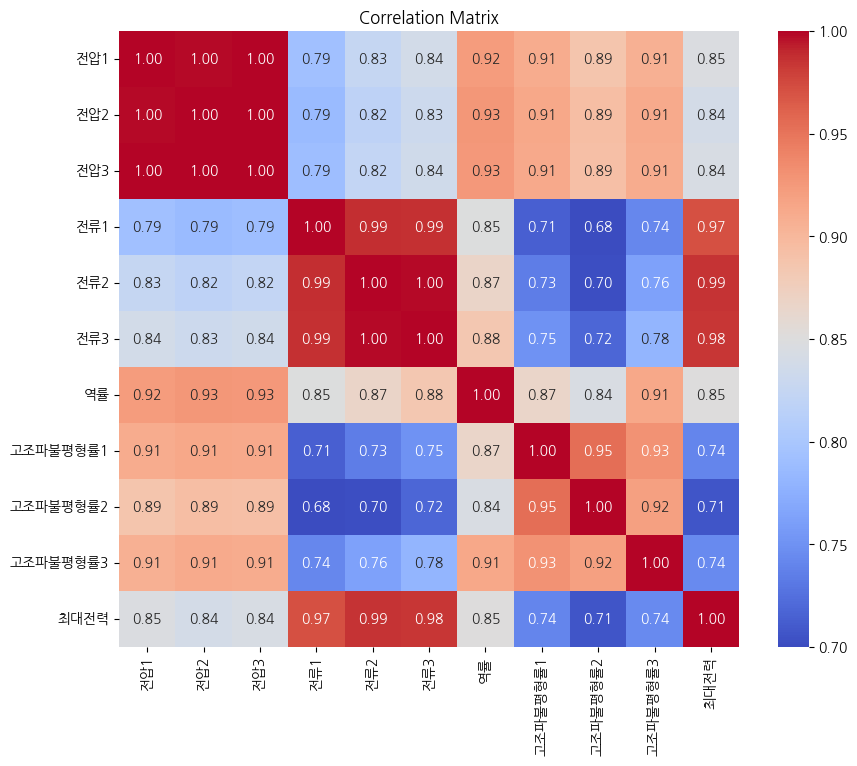

In [ ]:
cleaned_correlation_matrix = df_cleaned.corr()
# 정리된 데이터프레임의 상관계수 행렬 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(cleaned_correlation_matrix, annot=True, cmap='coolwarm',fmt=".2f", vmin=0.7, vmax=1)
plt.title('Correlation Matrix')
plt.show()

In [ ]:

# 독립 변수와 종속 변수 분리
X = df_cleaned[['전압1', '전압2', '전압3', '전류1', '전류2', '전류3', '역률', '고조파불평형률1', '고조파불평형률2', '고조파불평형률3']]
y = df_cleaned['최대전력']

# 학습 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
#새로 전처리한 데이터 학습 결과

# 머신러닝 모델 선택 및 학습(RandomForestRegressor)
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)

# 모델 평가
y_pred_rf = model_rf.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
print('MSE (Mean Squared Error)_RandomForest :', mse_rf)

# 교차 검증(RandomForest)
scores_rf = cross_val_score(model_rf, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print("교차검증(Cross-validated MSE)_RandomForest :", -scores_rf.mean())

# 상관 행렬 계산
correlation_matrix = X.corr()

# 한글 폰트 설정
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

# 예측값과 실제값의 차이 계산
percentage_diff = ((y_pred_rf - y_test) / y_test) * 100

# NaN 값을 제외하고 퍼센트 오차 출력
percentage_diff.dropna(inplace=True)
print("Percentage Difference:", percentage_diff)

# 예측값과 실제값이 100% 일치하는 비율 계산
accuracy_percentage = (percentage_diff.abs() <= 1).sum() / len(percentage_diff) * 100
print("Accuracy Percentage(예측값 정확도)", accuracy_percentage)

MSE (Mean Squared Error)_RandomForest : 3.902277362812535e-05
교차검증(Cross-validated MSE)_RandomForest : 6.990127586929745e-05
Percentage Difference: 35645    1.381641
19300   -0.271000
33035   -0.105955
16569    0.056946
18562   -0.715599
           ...   
29726   -0.196044
28705   -0.028856
36797   -0.102606
34177   -0.530336
22010    0.049940
Name: 최대전력, Length: 3625, dtype: float64
Accuracy Percentage(예측값 정확도) 98.62068965517241


MSE (Mean Squared Error)_RandomForest : 11972.181902964985
교차검증(Cross-validated MSE)_RandomForest : 5254.246970673006


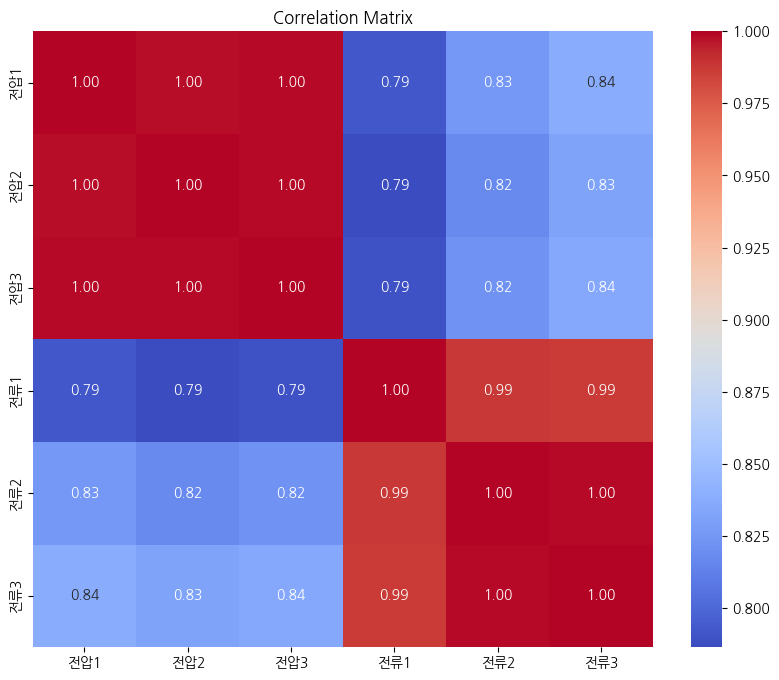

Percentage Difference: 20468   -0.065532
15306   -0.074754
25226   -0.341728
31744    0.183107
14601    0.427194
           ...   
23920   -0.022826
18770   -0.118544
18429   -0.320926
36555    0.032870
19501    0.093638
Name: 최대전력, Length: 3659, dtype: float64
Accuracy Percentage(예측값 정확도) 98.551516807871


In [ ]:

# 머신러닝 모델 선택 및 학습(RandomForestRegressor)
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)

# 모델 평가
y_pred_rf = model_rf.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
print('MSE (Mean Squared Error)_RandomForest :', mse_rf)

# 교차 검증(RandomForest)
scores_rf = cross_val_score(model_rf, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print("교차검증(Cross-validated MSE)_RandomForest :", -scores_rf.mean())

# 상관 행렬 계산
correlation_matrix = X.corr()

# 한글 폰트 설정
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

# 상관 행렬 히트맵 그리기
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", xticklabels=correlation_matrix.columns, yticklabels=correlation_matrix.columns)
plt.title('Correlation Matrix')
plt.show()

# 예측값과 실제값의 차이 계산
percentage_diff = ((y_pred_rf - y_test) / y_test) * 100

# NaN 값을 제외하고 퍼센트 오차 출력
percentage_diff.dropna(inplace=True)
print("Percentage Difference:", percentage_diff)

# 예측값과 실제값이 100% 일치하는 비율 계산
accuracy_percentage = (percentage_diff.abs() <= 1).sum() / len(percentage_diff) * 100
print("Accuracy Percentage(예측값 정확도)", accuracy_percentage)